<a href="https://www.kaggle.com/code/samuraiaish/optical-character-recognition-ocr-using-dl?scriptVersionId=174939717" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [24]:
# Default libraries, packages for data management, visualization and Computer vision libraries
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Sklearn package -> function
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Tensorflow packages
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Dropout, Conv2D, MaxPool2D, 
                                     BatchNormalization, Flatten, GlobalAveragePooling2D, Input)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.applications import EfficientNetB7, MobileNetV2, VGG19, DenseNet121

# 2) Helper Functions & Hyperparameters

- **This section to define all Helper functions through the notebook and any hyperparameters used later for training the models**

In [3]:
def directory_to_df(path : str):
    """
    This function to retrieve all images from targeted folder in a file, the
    folder must be divided hirarchally in which each class contains its images individually.
    ________________________________________________________________________________________________
    Arguments-
    
    path: String -> the main folder directory that contains train/test folders
    
    ________________________________________________________________________________________________
    Return-
    
    DataFrame: contains the images path and label corresponding to every image
    """
    df = []
    chars = 'abcdefghijklmnopqrstuvwxyz'    # to include lowercase letters only
    for cls in os.listdir(path):
        cls_path = os.path.join(path,cls)
        cls_name = cls.split('_')[0]
        if not cls_name in chars:
            continue
        for img_path in os.listdir(cls_path):
            direct = os.path.join(cls_path,img_path)
            df.append([direct,cls_name])
    
    df = pd.DataFrame(df, columns=['image','label'])
    print("The number of samples found:",len(df))
    return df.copy()

def read_image(path):
    """
    Read an image from specified directory
    _____________________________________________________________
    Arguments:
    
    path: String -> a directory of the image
    _____________________________________________________________
    Return:
    
    image: numpy.array of the image
    """
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def show_image(img, label=None) -> None:
    """
    This function to display any image
    _________________________________________________________
    Arguements:
    
    img: numpy.array of N-D
    
    label: String -> the title/label added with the image, Default= None
    _________________________________________________________
    Return:
    
    plt.imshow()
    """
    plt.imshow(img, cmap='gray')
    plt.axis(False)
    plt.title(label)
    plt.show()
    
def clbck(model_name):
    # The function is defined to make the callbacks for training the models
    ERLY = EarlyStopping(patience=10, min_delta=0.01, start_from_epoch=10, verbose=1)
    RD = ReduceLROnPlateau(patience=5, min_delta=0.01, factor=0.5)
    CHK = ModelCheckpoint(f'{model_name}_model.h5',verbose=1, save_best_only=True)
    return [ERLY,RD,CHK]

In [4]:
# Pre-defined hyperparameters
IMG_SHAPE = (32,32)
IMG_SIZE = (32,32,3)
BATCH_SIZE = 32
opt = Adam(learning_rate=0.00001, epsilon=1e-6)
loss = 'categorical_crossentropy'
EPOCHS = 25

# 3) Reading & preparing the dataset

In [5]:
# Reading the dataset in dataframe 
main_path = '/kaggle/input/ocr-dataset/dataset'
df = directory_to_df(main_path)                   # convert the dataset into df of two columns
df.head()

The number of samples found: 85199


,image,label
0,/kaggle/input/ocr-dataset/dataset/c_L/C_L_1241...,c
1,/kaggle/input/ocr-dataset/dataset/c_L/C_L_3096...,c
2,/kaggle/input/ocr-dataset/dataset/c_L/C_L_3184...,c
3,/kaggle/input/ocr-dataset/dataset/c_L/C_L_2981...,c
4,/kaggle/input/ocr-dataset/dataset/c_L/C_L_1635...,c


In [6]:
df['label'].value_counts()

label
r    3284
e    3284
n    3281
a    3281
m    3281
q    3279
u    3278
i    3277
d    3277
y    3276
x    3276
s    3276
l    3276
k    3276
t    3276
g    3275
w    3275
h    3275
z    3275
f    3275
p    3275
o    3275
b    3274
c    3274
j    3274
v    3274
Name: count, dtype: int64

## 3.1) Splitting the dataframe
- The dataframe is splitted to get 70% of the dataset for `training` , and 30% for `testing`
- The training set is splitted into `training` and `validation` to enhance the model training

In [7]:
# Splitting for training & testing (70,30 respectively)
X, y = df['image'], df['label']
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.30, random_state=41)
training_df = pd.concat((X_train,y_train), axis=1)
testing_df = pd.concat((X_test,y_test), axis=1)

In [8]:
# Splitting for training & validation (75,25 respectively) -> the training set size = 52.5%
X, y = training_df['image'], training_df['label']
X_train, X_valid, y_train, y_valid = train_test_split(X,y , test_size=0.25, random_state=41)
training_df = pd.concat((X_train,y_train), axis=1)
validation_df = pd.concat((X_valid,y_valid), axis=1)

## 3.2) Creating generators
- The `ImageDataGenerators` is used for data augmentation, the augmentation is required since the `OCR` can work with different brightness which is not included in the dataset.
- Also, it enhance the RAM usage.

In [9]:
# Creating generators
gen = ImageDataGenerator(dtype=np.int32, brightness_range=[0.0,1.0], fill_mode='nearest')
gen2 = ImageDataGenerator(dtype=np.int32, fill_mode='nearest')
train_gen = gen.flow_from_dataframe(training_df, x_col='image',y_col='label', batch_size=BATCH_SIZE, 
                                   target_size=IMG_SHAPE)
valid_gen = gen2.flow_from_dataframe(validation_df, x_col='image', y_col='label', batch_size=BATCH_SIZE, 
                                        target_size=IMG_SHAPE, shuffle=False)
test_gen = gen2.flow_from_dataframe(testing_df, x_col='image', y_col='label', batch_size=BATCH_SIZE, 
                                       target_size=IMG_SHAPE, shuffle=False)

Found 44729 validated image filenames belonging to 26 classes.
Found 14910 validated image filenames belonging to 26 classes.
Found 25560 validated image filenames belonging to 26 classes.


In [10]:
# Making a mapping of the classes and the inverse for later processings
mapping = train_gen.class_indices
mapping_inverse = dict(map(lambda x: tuple(reversed(x)), mapping.items()))

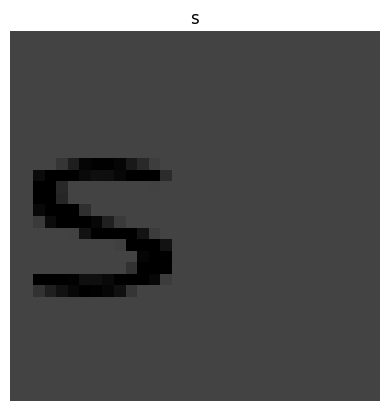

The shape of the image: (32, 32, 3)


In [11]:
# Reading a sample from the dataset
BATCH_NUM = 10
IMG_NUM = 2      # from 0 to 31
show_image(train_gen[BATCH_NUM][0][IMG_NUM],mapping_inverse[train_gen[BATCH_NUM][1][IMG_NUM].argmax()])
print('The shape of the image:',train_gen[BATCH_NUM][0][IMG_NUM].shape)

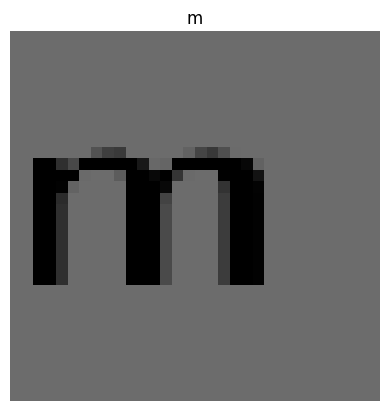

The shape of the image: (32, 32, 3)


In [12]:
# Reading another sample from the dataset
BATCH_NUM = 65
IMG_NUM = 30      # from 0 to 31
show_image(train_gen[BATCH_NUM][0][IMG_NUM],mapping_inverse[train_gen[BATCH_NUM][1][IMG_NUM].argmax()])
print('The shape of the image:',train_gen[BATCH_NUM][0][IMG_NUM].shape)

DenseNet121 

In [13]:
# DenseNset121 input layers will not be FREEZED
train_layers = DenseNet121(include_top=False, input_shape=IMG_SIZE)
Den = Sequential()
Den.add(train_layers)
Den.add(Flatten())
Den.add(Dense(1024, activation='selu'))
Den.add(Dense(512, activation='selu'))
Den.add(Dense(len(mapping), activation='softmax'))

29084464/29084464 [==============================] - 0s 0us/step


In [14]:
Den.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 1, 1, 1024)        7037504   
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 26)                13338     
                                                                 
Total params: 8625242 (32.90 MB)
Trainable params: 8541594 (32.58 MB)
Non-trainable params: 83648 (326.75 KB)
_________________________________________________________________


In [15]:
optimizer = tf.keras.optimizers.legacy.Adam()
Den.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [17]:
history5 = Den.fit(train_gen, validation_data=valid_gen, epochs=25, callbacks=clbck("DenseNet121"))

Epoch 1/25
1398/1398 [==============================] - ETA: 0s - loss: 0.6987 - accuracy: 0.8116
Epoch 1: val_loss improved from inf to 0.84552, saving model to DenseNet121_model.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1398/1398 [==============================] - 111s 80ms/step - loss: 0.6987 - accuracy: 0.8116 - val_loss: 0.8455 - val_accuracy: 0.7856 - lr: 0.0010
Epoch 2/25
1398/1398 [==============================] - ETA: 0s - loss: 0.5634 - accuracy: 0.8493
Epoch 2: val_loss improved from 0.84552 to 0.41364, saving model to DenseNet121_model.h5
1398/1398 [==============================] - 77s 55ms/step - loss: 0.5634 - accuracy: 0.8493 - val_loss: 0.4136 - val_accuracy: 0.8942 - lr: 0.0010
Epoch 3/25
1397/1398 [============================>.] - ETA: 0s - loss: 0.6951 - accuracy: 0.8138
Epoch 3: val_loss did not improve from 0.41364
1398/1398 [==============================] - 77s 55ms/step - loss: 0.6952 - accuracy: 0.8137 - val_loss: 1.0695 - val_accuracy: 0.7150 - lr: 0.0010
Epoch 4/25
1398/1398 [==============================] - ETA: 0s - loss: 0.7921 - accuracy: 0.7827
Epoch 4: val_loss did not improve from 0.41364
1398/1398 [==============================] - 76s 54ms/step - loss: 0.7921 - ac

In [ ]:
plt.plot(history5.history['loss'], label='Training loss')
plt.plot(history5.history['val_loss'], label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.title("DenseNet121 Training VS. Validation performance")
plt.show()

In [ ]:
# Making a prediction out of the DenseNet121 for the testing set for the evaluation
prediction = Den.predict(test_gen)
pred = list(map(lambda x: mapping_inverse[np.argmax(x)], prediction))
y_test = list(map(lambda x: mapping_inverse[x],test_gen.classes))

In [ ]:
print('\t\tThe DenseNet121 Evaluation Performance')
print(classification_report(y_test, pred))

In [ ]:
Den.save('densenet.h5')

In [29]:
# Computer Vision - Low level techniques
def load_model():
    model_path = '/kaggle/working/DenseNet121_model.h5'
    model = tf.keras.saving.load_model(model_path)
    return model

def convert_2_gray(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return gray_image

def binarization(image):
    img, thresh = cv2.threshold(image, 0,255, cv2.THRESH_OTSU|cv2.THRESH_BINARY_INV)
    return img, thresh

def dilate(image, words= False):
    img = image.copy()
    m = 3
    n = m - 2                   # n less than m for Vertical structuring element to dilate chars
    itrs = 4
    if words:
        m = 6
        n = m
        itrs = 3
    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (n, m))
    dilation = cv2.dilate(img, rect_kernel, iterations = itrs)
    return dilation

def find_rect(image):
    contours, hierarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    rects = []
    
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)  # Extract the bounding rectangle coordinates of each countour
        rects.append([x,y,w,h])
        
    sorted_rects = list(sorted(rects, key=lambda x: x[0])) # Sorting the rects from Left-to-Right
    return sorted_rects

# def extract(image):
#     model = load_model()
#     chars = []              # a list to store recognized characters
    
#     image_cpy = image.copy()
#     _, bin_img = binarization(convert_2_gray(image_cpy))
#     full_dil_img = dilate(bin_img,words=True)
#     words = find_rect(full_dil_img)                       # Recognized words within the image 
#     del _, bin_img, full_dil_img                          # for better memory usage
    
#     for word in words:
#         x,y,w,h = word                                    # coordinates of the word
#         img = image_cpy[y:y+h, x:x+w]
        
#         _, bin_img = binarization(convert_2_gray(img))
#         dil_img = dilate(bin_img)
#         char_parts = find_rect(dil_img)                     # Recognized chars withtin the word
#         cv2.rectangle(image, (x,y),(x+w,y+h), (0,255,0), 3) # draw a green rectangle around the word
        
#         del _, bin_img, dil_img
        
#         for char in char_parts:    
#             x,y,w,h = char
#             ch = img[y:y+h, x:x+w]
            
#             empty_img = np.full((32,32,1),255, dtype=np.uint8) # a white image used for resize with filling
#             x,y = 3,3                                          # starting indecies
#             resized = cv2.resize(ch, (16,22), interpolation=cv2.INTER_CUBIC)
#             gray = convert_2_gray(resized)
#             empty_img[y:y+22, x:x+16,0] = gray.copy()          # integrate the recognized char into the white image
#             gray = cv2.cvtColor(empty_img, cv2.COLOR_GRAY2RGB)
#             gray = gray.astype(np.int32)
            
#             predicted = mapping_inverse[np.argmax(model.predict(np.array([gray]), verbose=-1))]
#             chars.append(predicted)                            # append the character into the list
            
#             del ch, resized, gray, empty_img
#         chars.append(' ')  # at the end of each iteration (end of word) append a space
        
#     del model
#     show_image(image)
#     return ''.join(chars[:-1])

In [33]:
def extract(image):
    model = load_model()
    chars = []              # a list to store recognized characters
    
    image_cpy = image.copy()
    _, bin_img = binarization(convert_2_gray(image_cpy))
    full_dil_img = dilate(bin_img, words=True)
    words = find_rect(full_dil_img)                       # Recognized words within the image 
    del _, bin_img, full_dil_img                          # for better memory usage
    
    for word in words:
        x, y, w, h = word                                    # coordinates of the word
        img = image_cpy[y:y+h, x:x+w]
        
        _, bin_img = binarization(convert_2_gray(img))
        dil_img = dilate(bin_img)
        char_parts = find_rect(dil_img)                     # Recognized chars within the word
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 3)  # draw a green rectangle around the word
        
        del _, bin_img, dil_img
        
        for char in char_parts:    
            x_c, y_c, w_c, h_c = char
            ch = img[y_c:y_c+h_c, x_c:x_c+w_c]
            
            empty_img = np.full((32, 32, 1), 255, dtype=np.uint8)  # a white image used for resize with filling
            x_fill, y_fill = 3, 3                                 # starting indices
            resized = cv2.resize(ch, (16, 22), interpolation=cv2.INTER_CUBIC)
            gray = convert_2_gray(resized)
            empty_img[y_fill:y_fill+22, x_fill:x_fill+16, 0] = gray.copy()  # integrate the recognized char into the white image
            gray = cv2.cvtColor(empty_img, cv2.COLOR_GRAY2RGB)
            gray = gray.astype(np.int32)
            
            predicted = mapping_inverse[np.argmax(model.predict(np.array([gray]), verbose=-1))]
            chars.append(predicted)  # append the character into the list
            
            # Calculate position to draw the text at the bottom of the rectangle
            text_x = x + x_c
            text_y = y + y_c + h_c
            
            # Overlay the recognized character on the original image with increased size and black color
            cv2.putText(image, predicted, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 0), 3, cv2.LINE_AA)
            
            del ch, resized, gray, empty_img
        chars.append(' ')  # at the end of each iteration (end of word) append a space
        
    del model
    show_image(image)
    return ''.join(chars[:-1])


## 6.1) Testing

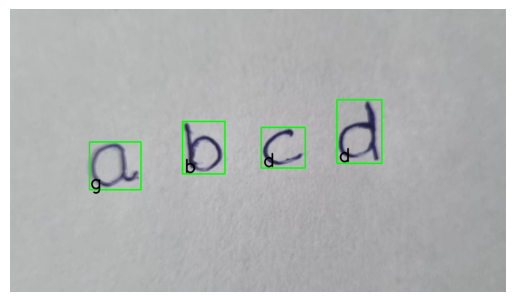

--> g b d d


In [34]:
# Testing 1
img = read_image('/kaggle/input/test-3/WhatsApp Image 2024-04-19 at 21.39.26.jpeg')
text = extract(img)
print('-->',text)

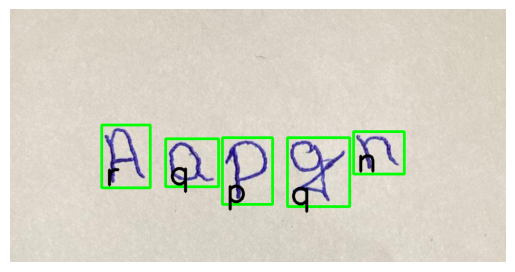

--> r q p q n


In [37]:
# Testing 2
img2 = read_image('/kaggle/input/ttyiou/WhatsApp Image 2024-04-19 at 22.37.15.jpeg')
text = extract(img2)
print('-->',text)

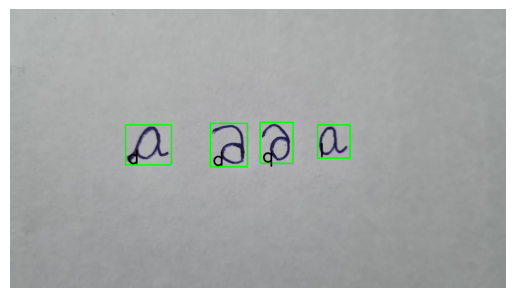

--> d d q l


In [35]:
# Testing 3
img3 = read_image('/kaggle/input/qwerty/WhatsApp Image 2024-04-19 at 22.41.52.jpeg')
text = extract(img3)
print('-->',text)